In [ ]:
import os
import torch
import numpy as np
import torch.nn as nn
from PIL import Image
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline

In [ ]:
print(os.getcwd())

C:\Users\hrith\OneDrive\Desktop\Lecture Files\LSTM-project\Siemese Network


In [ ]:
os.getcwd()

'C:\\Users\\hrith\\OneDrive\\Desktop\\Lecture Files\\LSTM-project\\Siemese Network'

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Load pre-trained VGG16 model
        vgg16 = models.vgg16(weights="VGG16_Weights.IMAGENET1K_V1")

        # Freeze the VGG16 layers
        for param in vgg16.parameters():
            param.requires_grad = False

        # Remove last layer
        self.vgg16_features = nn.Sequential(*list(vgg16.features.children())[:-1])
        # Get the output size of the VGG16 features
        vgg_output_size = self._get_vgg_output_size()

        # Add fully connected layer with 128 dimensions
        self.fc = nn.Linear(vgg_output_size, 128)
    def _get_vgg_output_size(self):

        # Create a dummy input tensor to get the output size of the VGG16 features
        dummy_input = torch.zeros(1, 3, 224, 224)
        dummy_output = self.vgg16_features(dummy_input)
        return dummy_output.view(dummy_output.size(0), -1).size(1)


#         # Define the image transformation required for VGG16
#         self.transform = transforms.Compose([
#             transforms.Resize((224, 224)),
#             transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#         ])

#     def forward_once(self, x):
#         x = self.transform(x)
#         x = self.vgg16_features(x)
#         x = x.view(x.size()[0], -1)
#         x = self.fc(x)
#         return x

    def forward_once(self, x):
#         x = self.transform(x).unsqueeze(0)
        x = self.vgg16_features(x)
        x = x.view(x.size()[0], -1)
        x = self.fc(x)
        return x

    def forward(self, image1, image2, image3):
        embedding1 = self.forward_once(image1)
        embedding2 = self.forward_once(image2)
        embedding3 = self.forward_once(image3)
        return embedding1, embedding2, embedding3



In [ ]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = torch.pairwise_distance(anchor, positive)
        distance_negative = torch.pairwise_distance(anchor, negative)
        loss = torch.relu(distance_positive - distance_negative + self.margin)
        return loss.mean()



In [ ]:
class TripletDataset(Dataset):
    def __init__(self, root_folder="C:\\Users\\hrith\\OneDrive\\Desktop\\Lecture Files\\LSTM-project\\Siemese Network\\triplet_dataset", transform=None):
        self.root_folder = root_folder
        self.triplets = []
        self.transform = transform

        for i in range(1, 1201):
            subfolder = os.path.join(root_folder, f"iteration_{i}")
            image_files = [os.path.join(subfolder, f"person_{i}_image{j}.jpg") for j in range(1, 4)]
            self.triplets.append(image_files)

#     def __getitem__(self, index):
#         image_files = self.triplets[index]
#         images = [Image.open(file) for file in image_files]
#         images = [self.transform(image) for image in images]
#         return images[0], images[1], images[2]
#     def __getitem__(self, index):
#         image_files = self.triplets[index]
#         images = [Image.open(file) for file in image_files]
#         images = [self.transform(image) for image in images]
#         images = [image.squeeze(0) for image in images]  # Squeeze the dimensions
#         return images[0], images[1], images[2]
    def __getitem__(self, index):
        image_files = self.triplets[index]
        images = [Image.open(file) for file in image_files]
        images = [image.convert("RGB") for image in images]  # Convert to RGB if necessary
        images = [self.transform(image) for image in images]
        images = [image.squeeze(0) for image in images]  # Squeeze the dimensions
        return images[0], images[1], images[2]
    def __len__(self):
        return len(self.triplets)


In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Example usage
model = SiameseNetwork()
# Freeze the VGG16 layers
for param in model.vgg16_features.parameters():
    param.requires_grad = False

# Only train the fc layer
for param in model.fc.parameters():
    param.requires_grad = True

criterion = TripletLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)


In [ ]:
# from PIL import Image

# def load_image(file_path):
#     image = Image.open(file_path)
#     return image

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Load the dataset
root_folder = "C:\\Users\\hrith\\OneDrive\\Desktop\\Lecture Files\\LSTM-project\\Siemese Network\\triplet_dataset"
dataset = TripletDataset(root_folder,transform=transform)
data_loader = DataLoader(dataset, batch_size=5, shuffle=True)

In [ ]:
# Training loop
num_epochs = 2
for epoch in range(num_epochs):
    total_loss = 0.0
    for batch in data_loader:
        # Unpack the batch
        images1, images2, images3 = batch

        # Move images to GPU if available
        images1 = images1.to(device)
        images2 = images2.to(device)
        images3 = images3.to(device)

        # Forward pass
        embeddings1, embeddings2, embeddings3 = model(images1, images2, images3)
        loss = criterion(embeddings1, embeddings2, embeddings3)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Print average loss for the epoch
    average_loss = total_loss / len(data_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")

Epoch [1/2], Loss: 0.7944
Epoch [2/2], Loss: 0.1018


In [ ]:
torch.save(model, "siamese_model.pth")
# loaded_model = torch.load("siamese_model.pth")

In [ ]:
torch.save(model.state_dict(), "siamese_model1.pth")

# Checking the trained model on friends data using cosine similartiy

In [ ]:
ls


 Volume in drive C is Windows
 Volume Serial Number is CE09-0150

 Directory of C:\Users\hrith\OneDrive\Desktop\Lecture Files\LSTM-project\Siemese Network

15-10-2023  16:16    <DIR>          .
06-10-2023  19:25    <DIR>          ..
15-10-2023  13:24    <DIR>          .ipynb_checkpoints
15-10-2023  16:16            10,862 Building_a_siemese_network_model.ipynb
11-10-2023  10:01            11,325 Creating_train_dev_test_split.ipynb
14-10-2023  18:40            36,306 Creating_triplet_loss_dataset.ipynb
10-10-2023  19:36    <DIR>          data
10-10-2023  19:35    <DIR>          dev
06-10-2023  19:27           464,006 EE782 2023 A2.pdf
13-10-2023  12:01    <DIR>          face-detection-yolov8
10-10-2023  19:34    <DIR>          lfw
10-10-2023  18:34       180,566,744 lfw (1).tgz
15-10-2023  16:09       110,256,773 siamese_model.pth
10-10-2023  19:36    <DIR>          test
10-10-2023  19:34    <DIR>          train
14-10-2023  18:38    <DIR>          triplet_dataset
               6 File(s

In [ ]:
ls

 Volume in drive C is Windows
 Volume Serial Number is CE09-0150

 Directory of C:\Users\hrith\OneDrive\Desktop\Lecture Files\LSTM-project\Siemese Network

15-10-2023  16:21    <DIR>          .
06-10-2023  19:25    <DIR>          ..
15-10-2023  13:24    <DIR>          .ipynb_checkpoints
15-10-2023  16:20            15,219 aniket1.jpg
15-10-2023  16:20             9,728 aniket2.jpg
15-10-2023  16:21            12,435 Building_a_siemese_network_model.ipynb
11-10-2023  10:01            11,325 Creating_train_dev_test_split.ipynb
14-10-2023  18:40            36,306 Creating_triplet_loss_dataset.ipynb
10-10-2023  19:36    <DIR>          data
10-10-2023  19:35    <DIR>          dev
06-10-2023  19:27           464,006 EE782 2023 A2.pdf
13-10-2023  12:01    <DIR>          face-detection-yolov8
10-10-2023  19:34    <DIR>          lfw
10-10-2023  18:34       180,566,744 lfw (1).tgz
15-10-2023  16:20            10,557 Peus.jpg
15-10-2023  16:09       110,256,773 siamese_model.pth
10-10-2023  19:36

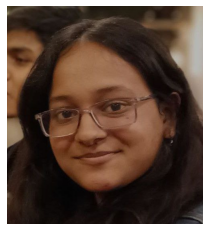

In [ ]:
# Load the image
image_path = "chomtu.jpg"
image = mpimg.imread(image_path)

# Display the image
plt.imshow(image)
plt.axis('off')  # Turn off the axis labels
plt.show()

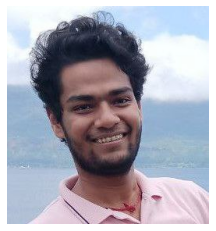

In [ ]:
# Load the image
image_path = "aniket1.jpg"
image = mpimg.imread(image_path)

# Display the image
plt.imshow(image)
plt.axis('off')  # Turn off the axis labels
plt.show()

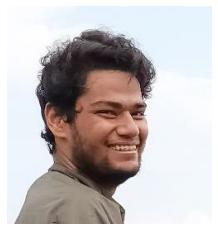

In [ ]:
# Load the image
image_path = "aniket2.jpg"
image = mpimg.imread(image_path)

# Display the image
plt.imshow(image)
plt.axis('off')  # Turn off the axis labels
plt.show()

In [ ]:
image_path = "chomtu.jpg"
image = Image.open(image_path)
transformed_image = transform(image).unsqueeze(0)

# Pass the transformed image through the model
chomtu_em = model.forward_once(transformed_image)
chomtu_em=chomtu_em.detach().numpy()



In [ ]:
image_path = "aniket1.jpg"
image = Image.open(image_path)
transformed_image = transform(image).unsqueeze(0)

# Pass the transformed image through the model
aniket1_em = model.forward_once(transformed_image)
aniket1_em=aniket1_em.detach().numpy()


In [ ]:
image_path = "aniket2.jpg"
image = Image.open(image_path)
transformed_image = transform(image).unsqueeze(0)

# Pass the transformed image through the model
aniket2_em = model.forward_once(transformed_image)
aniket2_em=aniket2_em.detach().numpy()


In [ ]:
similarity_same_images = cosine_similarity(chomtu_em, aniket2_em)
print(similarity_same_images)

[[0.4120744]]


In [ ]:
similarity_same_images = cosine_similarity(aniket2_em, aniket1_em)
print(similarity_same_images)

[[0.7677909]]


In [ ]:
# The model has not only been trained for 2 epoch still gave good results,
#if we train for more epoch we may get even better results

In [ ]:
os.getcwd()

'C:\\Users\\hrith\\OneDrive\\Desktop\\Lecture Files\\LSTM-project\\Siemese Network'

# Testing on "test_dataset"

In [ ]:
# Initialize the count variable
count = 0

# Iterate over the subfolders
for i in range(1, 141):
    subfolder_path = f"triplet_dataset_test/iteration_{i}/"

    # Load the three images in the subfolder
    image1 = Image.open(subfolder_path + f"person_{i}_image1.jpg")
    image2 = Image.open(subfolder_path + f"person_{i}_image2.jpg")
    image3 = Image.open(subfolder_path + f"person_{i}_image3.jpg")

    # Apply the image transformation
    image1 = transform(image1)
    image2 = transform(image2)
    image3 = transform(image3)

    # Add a batch dimension to the images
    image1 = image1.unsqueeze(0)
    image2 = image2.unsqueeze(0)
    image3 = image3.unsqueeze(0)

    # Forward pass through the model
    embedding1=model.forward_once(image1)
    embedding2=model.forward_once(image2)
    embedding3=model.forward_once(image3)


    # Calculate the cosine similarity
    similarity_12 = cosine_similarity(embedding1.detach().numpy(), embedding2.detach().numpy())
    similarity_23 = cosine_similarity(embedding2.detach().numpy(), embedding3.detach().numpy())

    # Check if similarity_12 is larger than similarity_23
    if similarity_12 > similarity_23:
        count += 1

# Print the final count
print("Count:", count)

Count: 122


# Out of 140 train examples 122 gave right answers

In [ ]:
accuracy = 122/140*100

In [ ]:
print(accuracy)

87.14285714285714
